In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader
import geodatasets
import xarray as xr
import numpy as np
from geopandas import GeoSeries
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import Point , Polygon, MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.wkt
import shapely.geometry
import shapely
from shapely.ops import nearest_points
from pathlib import Path
import rasterio
import rioxarray

In [2]:
### First I try to create buffer area regarding criterions of suitabilit index ### 
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]
xr_landuse = xr.open_dataset("Data//dataset-satellite-land-cover//C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2022-01-01')
xr_landuse = xr_landuse.drop_vars('time')
lccs_resolution = 300 ## meters ##

## only settlement area ## 
xr_landuse['settlementarea'] = xr.where((xr_landuse['lccs_class'].isin([190])),190,0)
df_landuse_settlementarea = xr_landuse['settlementarea'].to_dataframe()
df_landuse_settlementarea.reset_index(inplace=True)

df_landuse_settlementarea = gpd.GeoDataFrame(df_landuse_settlementarea, geometry =gpd.points_from_xy(df_landuse_settlementarea['lon'],df_landuse_settlementarea['lat']))
df_landuse_settlementarea.crs = {'init': 'epsg:4326'}
df_landuse_settlementarea = df_landuse_settlementarea.to_crs({'init': 'epsg:3857'})

df_landuse_distancetosettlement = df_landuse_settlementarea
df_landuse_settlementarea = df_landuse_settlementarea.loc[df_landuse_settlementarea['settlementarea'] == 190]

## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.to_crs({'init': 'epsg:3857'})
boundaries = boundaries.geometry.unary_union

## I filter out area outside of THailand ## 
df_landuse_settlementarea = df_landuse_settlementarea.loc[df_landuse_settlementarea.within(boundaries)]
df_landuse_settlementarea.reset_index(inplace=True,drop=True)


df_distancetosettlement = gpd.sjoin_nearest(df_landuse_distancetosettlement,df_landuse_settlementarea,distance_col="distance",how='left')

print(df_distancetosettlement.columns)
for i in df_distancetosettlement.columns:
    if i not in (['lon_left','lat_left','settlementarea_left','distance','geometry']):
        df_distancetosettlement = df_distancetosettlement.drop(columns=i)

df_distancetosettlement = df_distancetosettlement.rename(columns= {'lon_left' : 'lon'})
df_distancetosettlement = df_distancetosettlement.rename(columns= {'lat_left' : 'lat'})
df_distancetosettlement = df_distancetosettlement.rename(columns= {'settlementarea_left' : 'SI_DtoSettlement'})

df_distancetosettlement.reset_index(inplace=True,drop=True)
try: 
    df_distancetosettlement = df_distancetosettlement.drop(columns=['geometry'])
except:
    None

print(df_distancetosettlement.columns)
df_distancetosettlement = df_distancetosettlement.groupby(['lat', 'lon']).agg('mean')
df_distancetosettlement.reset_index(inplace=True)
df_distancetosettlement = df_distancetosettlement.set_index(['lat', 'lon'])
print(df_distancetosettlement)

xr_distancetosettlement = xr.Dataset.from_dataframe(df_distancetosettlement)
print(xr_distancetosettlement)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_30912\1008904839.py:28: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0.

Index(['lat_left', 'lon_left', 'settlementarea_left', 'geometry',
       'index_right', 'lat_right', 'lon_right', 'settlementarea_right',
       'distance'],
      dtype='object')
Index(['lat', 'lon', 'SI_DtoSettlement', 'distance'], dtype='object')
                      SI_DtoSettlement       distance
lat       lon                                        
5.615278  97.345833                0.0  269051.562602
          97.348611                0.0  268924.837186
          97.351389                0.0  268798.407747
          97.354167                0.0  268672.274703
          97.356944                0.0  268546.438472
...                                ...            ...
20.462500 105.623611               0.0  330622.602892
          105.626389               0.0  330776.857449
          105.629167               0.0  330931.329040
          105.631944               0.0  331086.017360
          105.634722               0.0  331240.922105

[15957810 rows x 2 columns]
<xarray.Dataset>
Di

In [3]:
df_distancetosettlement = xr_distancetosettlement.to_dataframe()
df_distancetosettlement.reset_index(inplace=True)
df_distancetosettlement = gpd.GeoDataFrame(df_distancetosettlement, geometry =gpd.points_from_xy(df_distancetosettlement['lon'],df_distancetosettlement['lat']))

df_distancetosettlement['SI_BGEC'] = 0
df_distancetosettlement['SI_Biomass'] = 0
df_distancetosettlement['SI_Solar'] = 0
df_distancetosettlement['SI_Wind'] = 0
df_distancetosettlement['SI_BGWW'] = 0
df_distancetosettlement['SI_MSW'] = 0
df_distancetosettlement['SI_IEW'] = 0

df_distancetosettlement = df_distancetosettlement.drop(columns='SI_DtoSettlement')

df_distancetosettlement['SI_BGEC'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_BGEC'].loc[df_distancetosettlement['distance'] >= (1000+lccs_resolution)] = 3

df_distancetosettlement['SI_Biomass'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_Biomass'].loc[df_distancetosettlement['distance'] >= (1000+lccs_resolution)] = 3

df_distancetosettlement['SI_Wind'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_Wind'].loc[(df_distancetosettlement['distance'] >= (1000+lccs_resolution)) & (df_distancetosettlement['distance'] < (3000+lccs_resolution))] = 2
df_distancetosettlement['SI_Wind'].loc[df_distancetosettlement['distance'] >= (3000+lccs_resolution)] = 3

df_distancetosettlement['SI_Solar'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_Solar'].loc[(df_distancetosettlement['distance'] >= (1000+lccs_resolution)) & (df_distancetosettlement['distance'] < (1500+lccs_resolution))] = 2
df_distancetosettlement['SI_Solar'].loc[df_distancetosettlement['distance'] >= (1500+lccs_resolution)] = 3

df_distancetosettlement['SI_BGWW'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_BGWW'].loc[df_distancetosettlement['distance'] >= (1000+lccs_resolution)] = 3

df_distancetosettlement['SI_MSW'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_MSW'].loc[(df_distancetosettlement['distance'] >= (1000+lccs_resolution)) & (df_distancetosettlement['distance'] < (1500+lccs_resolution))] = 1
df_distancetosettlement['SI_MSW'].loc[(df_distancetosettlement['distance'] >= (1500+lccs_resolution)) & (df_distancetosettlement['distance'] < (2000+lccs_resolution))] = 2
df_distancetosettlement['SI_MSW'].loc[df_distancetosettlement['distance'] >= (2000+lccs_resolution)] = 3

df_distancetosettlement['SI_IEW'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
df_distancetosettlement['SI_IEW'].loc[(df_distancetosettlement['distance'] >= (1000+lccs_resolution)) & (df_distancetosettlement['distance'] < (1500+lccs_resolution))] = 1
df_distancetosettlement['SI_IEW'].loc[(df_distancetosettlement['distance'] >= (1500+lccs_resolution)) & (df_distancetosettlement['distance'] < (2000+lccs_resolution))] = 2
df_distancetosettlement['SI_IEW'].loc[df_distancetosettlement['distance'] >= (2000+lccs_resolution)] = 3

xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')
df_landuse_suitability_index= xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))

df_distancetosettlement['SI_BGEC'].loc[df_landuse_suitability_index['SI_BGEC'] ==  0] = 0
df_distancetosettlement['SI_Biomass'].loc[df_landuse_suitability_index['SI_Biomass'] ==  0] = 0
df_distancetosettlement['SI_Wind'].loc[df_landuse_suitability_index['SI_Wind'] ==  0] = 0
df_distancetosettlement['SI_Solar'].loc[df_landuse_suitability_index['SI_Solar'] ==  0] = 0
df_distancetosettlement['SI_BGWW'].loc[df_landuse_suitability_index['SI_BGWW'] ==  0] = 0
df_distancetosettlement['SI_MSW'].loc[df_landuse_suitability_index['SI_MSW'] ==  0] = 0
df_distancetosettlement['SI_IEW'].loc[df_landuse_suitability_index['SI_IEW'] ==  0] = 0

print(df_distancetosettlement)

C:\Users\EGAT\AppData\Local\Temp\ipykernel_30912\1574087045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetosettlement['SI_BGEC'].loc[df_distancetosettlement['distance'] < (1000+lccs_resolution)] = 0
C:\Users\EGAT\AppData\Local\Temp\ipykernel_30912\1574087045.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetosettlement['SI_BGEC'].loc[df_distancetosettlement['distance'] >= (1000+lccs_resolution)] = 3
C:\Users\EGAT\AppData\Local\Temp\ipykernel_30912\1574087045.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  269051.562602    POINT (97.34583 5.61528)   
1          5.615278   97.348611  268924.837186    POINT (97.34861 5.61528)   
2          5.615278   97.351389  268798.407747    POINT (97.35139 5.61528)   
3          5.615278   97.354167  268672.274703    POINT (97.35417 5.61528)   
4          5.615278   97.356944  268546.438472    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  330622.602892  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  330776.857449  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  330931.329040  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  331086.017360  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  331240.922105  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_M

C:\Users\EGAT\AppData\Local\Temp\ipykernel_30912\1574087045.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetosettlement['SI_IEW'].loc[df_landuse_suitability_index['SI_IEW'] ==  0] = 0


In [4]:
print(df_distancetosettlement)
try: 
    df_distancetosettlement = df_distancetosettlement.drop(columns=['distance','geometry'])
except:
    None

df_distancetosettlement = df_distancetosettlement.groupby(['lat', 'lon']).agg('mean')
df_distancetosettlement.reset_index(inplace=True)
df_distancetosettlement = df_distancetosettlement.set_index(['lat', 'lon'])


xr_distancetosettlement = xr.Dataset.from_dataframe(df_distancetosettlement)
xr_distancetosettlement.to_netcdf(path='Output\\xr_SI_Distancetosettlementarea.nc')
print(xr_distancetosettlement)


                lat         lon       distance                    geometry  \
0          5.615278   97.345833  269051.562602    POINT (97.34583 5.61528)   
1          5.615278   97.348611  268924.837186    POINT (97.34861 5.61528)   
2          5.615278   97.351389  268798.407747    POINT (97.35139 5.61528)   
3          5.615278   97.354167  268672.274703    POINT (97.35417 5.61528)   
4          5.615278   97.356944  268546.438472    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  330622.602892  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  330776.857449  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  330931.329040  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  331086.017360  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  331240.922105  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_M

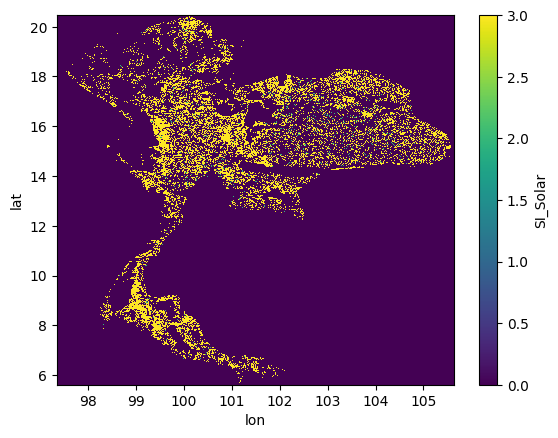

In [5]:
xr_distancetosettlement['SI_Solar'].plot()

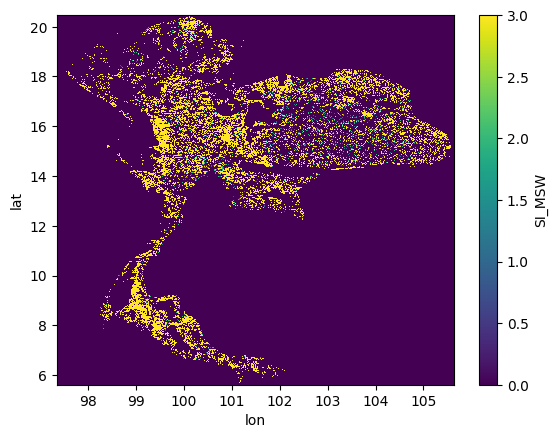

In [6]:
xr_distancetosettlement = xr.open_dataset("Output//xr_SI_Distancetosettlementarea.nc")
xr_distancetosettlement['SI_MSW'].plot()